In [1]:
from collections import OrderedDict
import datetime as dt
import pandas as pd
import alphalens as al
import numpy as np
import alphalens as al
import cvxpy as cvx
import os
import sys
import time
import matplotlib.pyplot as plt
import matplotlib.style as style
from scipy.stats.stats import pearsonr
from scipy.stats.stats import spearmanr
from statsmodels.formula.api import ols
from statistics import median
from scipy.optimize import fmin_l_bfgs_b
from sklearn.linear_model import LinearRegression
from tqdm import tqdm
from scipy.stats import gaussian_kde
style.use('ggplot')
from IPython.core.pylabtools import figsize
figsize(15, 5)

mod_path = '/Users/richard.wuebker/Projects/price_data_utils'
if mod_path not in sys.path:
    sys.path.append(mod_path)

libs_path = '/Users/richard.wuebker/Projects/backtesting/libs'
if libs_path not in sys.path:
    sys.path.append(libs_path)

    
from risk_model import RiskModelPCA
from optimal_holdings import OptimalHoldingsCVX
    
from data_loader import DataLoader
from mp_historical_prices import HistoricalPrices

In [2]:
dl = DataLoader(prices_dir='../../price_data_utils/prices', info_dir='../../price_data_utils/info', 
                analysis_date_str='2019-08-07', cached_dir='../../price_data_utils/cached')
dl.load_data()
data = dl.data

Prediction Date: 2019-08-09


In [3]:
hp = HistoricalPrices(prices_dir='../../price_data_utils/prices', 
                      cached_dir='../../price_data_utils/cached',
                      date_str='2019-08-09')
hp.get_prices()
prices = hp.prices

# look for duplicates
p = prices.reset_index()
p.loc[p.duplicated(subset=['Date', 'ticker'], keep='first')]

,index,Date,High,Low,Open,Close,Volume,Adj Close,ticker


In [4]:
prices.head()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
0,1990-01-02,17.947027,17.527565,17.557526,17.947027,626200.0,7.267582,KMB
1,1990-01-03,17.976990,17.827181,17.976990,17.887104,749200.0,7.243319,KMB
2,1990-01-04,17.976990,17.797220,17.857143,17.857143,439700.0,7.231189,KMB
3,1990-01-05,17.857143,17.617449,17.797220,17.737297,712500.0,7.182656,KMB
4,1990-01-08,17.917067,17.707335,17.737297,17.917067,495600.0,7.255455,KMB


In [5]:
prices.tail()

,Date,High,Low,Open,Close,Volume,Adj Close,ticker
4933501,2019-08-05,38.950001,38.009998,38.709999,38.360001,1900600.0,38.360001,AL
4933502,2019-08-06,39.180000,38.049999,38.689999,38.860001,577500.0,38.860001,AL
4933503,2019-08-07,38.950001,37.709999,38.040001,38.700001,923700.0,38.700001,AL
4933504,2019-08-08,40.250000,38.919998,38.950001,40.169998,809000.0,40.169998,AL
4933505,2019-08-09,40.549999,38.209999,39.939999,40.110001,1047265.0,40.110001,AL


In [6]:
def transform_prices(df, end_date_str):
    prices_temp = df.pivot(index='Date', columns='ticker', values='Adj Close')
    end_date = dt.datetime.strptime(end_date_str, '%Y-%m-%d')
    start_date = end_date - pd.DateOffset(years=5)
    prices_temp.index = pd.to_datetime(prices_temp.index)
    prices = prices_temp.loc[start_date:end_date]
    return prices.dropna(axis=1)
new_p = transform_prices(prices, '2016-01-05')

In [7]:
# to make the index of data we have with sector the same as in returns and prices

sector_data = data['sector']
index_ = sector_data.index.intersection(new_p.columns)
sector_data = sector_data.loc[index_]
p = new_p.loc[:, index_].copy() # to use only the stocks that are in sector_data
sectors = sector_data.unique()

In [8]:
returns = p.pct_change().drop(p.index[0])
print(returns.shape)
print(sector_data.shape)
print(p.shape)

(1257, 741)
(741,)
(1258, 741)


In [9]:
p.head()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-05,16.319235,25.350000,50.676487,91.209999,692.690002,59.998005,28.536177,40.534866,70.415245,34.523262,...,14.976269,77.790001,17.154980,33.694031,43.528183,23.909542,14.824180,6.94250,151.752335,16.587673
2011-01-06,16.460661,25.750000,50.676487,89.559998,718.400024,62.723892,28.326279,40.797176,69.994743,34.397305,...,14.842355,76.050003,16.839489,33.711502,43.555824,23.958487,14.856651,6.83000,150.116272,16.470205
2011-01-07,16.476372,25.950001,50.264294,89.133331,735.150024,62.590939,28.334854,40.758602,70.200493,34.976746,...,14.686119,75.209999,16.681742,33.589188,43.472923,24.031902,14.669928,6.69375,148.875351,16.315643
2011-01-10,16.334949,26.200001,50.342079,90.526665,749.960022,62.932850,28.647541,41.267784,70.057358,35.111115,...,14.358768,74.680000,16.497704,33.807583,44.891319,24.553984,14.678050,6.90250,151.096298,16.290915
2011-01-11,16.405655,25.690001,50.715374,93.663330,751.900024,63.474232,29.354307,41.653553,72.347855,35.279057,...,14.336452,76.300003,16.333384,33.982292,45.572895,24.456089,14.507563,6.79875,152.874680,16.303284


In [10]:
p.tail()

ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2015-12-29,24.640928,59.299999,66.267441,184.456665,1650.000000,141.577072,48.883698,29.317432,31.023300,45.610756,...,29.112070,136.169998,34.340061,73.815681,75.976669,35.107853,39.816341,41.125000,314.309814,29.093164
2015-12-30,24.427971,57.509998,65.351830,184.169998,1649.540039,140.273254,48.753433,29.024263,29.830099,45.245197,...,28.986509,135.639999,34.271770,73.255249,75.430962,35.071419,39.375340,40.480000,312.891907,29.008694
2015-12-31,24.099659,57.299999,64.807915,182.053329,1643.000000,139.751724,48.278931,29.077566,30.792358,44.842140,...,28.520142,134.580002,34.186417,72.770805,74.725288,34.515739,39.672337,40.305000,311.492279,28.831297
2016-01-04,23.616772,55.610001,63.629417,182.463333,1555.660034,137.626907,48.325451,29.886017,31.100277,44.710915,...,27.910280,130.350006,33.768162,71.944405,73.135201,34.415535,39.096333,39.830002,304.704834,28.451166
2016-01-05,23.509462,55.060001,63.892326,183.986664,1594.089966,137.800766,48.167278,30.179193,31.591042,44.542198,...,28.170368,129.809998,34.382748,71.241478,73.530373,33.559250,39.078335,40.075001,305.491516,28.755270


In [11]:
def create_momentum_factor(prices, sector_data):

    # demean by sector
    df = prices.pct_change(252).dropna()
    sectors = sector_data.unique()
    
    # demean by sector
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [12]:
momentum = create_momentum_factor(p, sector_data)
print(momentum.shape)
print(momentum.index[0])
print(momentum.index[-1])
momentum.head()

(1006, 741)
2012-01-05 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.476518,-1.382838,-0.196213,1.686502,-0.583969,1.532334,1.130563,0.752152,-1.256701,1.027785,...,0.355053,-0.551266,0.219572,-0.182198,-1.004426,1.588395,-1.065159,1.275388,0.233587,-0.149496
2012-01-09,-0.513892,-1.448242,-0.294320,1.663143,-0.738136,1.513647,1.172609,0.752152,-1.130563,1.023113,...,0.327022,-0.537251,0.303664,-0.144824,-0.976396,1.588395,-1.027785,1.340792,0.154168,0.070076
2012-01-10,-0.551266,-1.508975,-0.163511,1.649128,-0.896976,1.555693,1.125892,0.569953,-1.191296,1.027785,...,0.415786,-0.560610,0.336366,-0.228916,-1.097861,1.522990,-1.069831,1.261372,0.116794,-0.004672
2012-01-11,-0.527908,-1.457586,-0.303664,1.649128,-0.873617,1.504303,1.083846,0.284977,-1.219327,1.018441,...,0.485862,-0.551266,0.355053,-0.228916,-1.079174,1.518319,-0.995083,1.331449,0.130809,-0.121465


In [13]:
def create_mean_reversion_factor(window_length, prices, sector_data):
    sectors = sector_data.unique()
    df = prices.pct_change(window_length).dropna()
    for sector in sectors:
        col_filter = sector_data[sector_data==sector].index
        means = df.loc[:, col_filter].mean(axis=1)
        df.loc[:, col_filter] = df.loc[:, col_filter].subtract(means, axis=0)
        
    ranked = df.rank(axis=1, method='first', ascending=False)
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [14]:
mean_reversion = create_mean_reversion_factor(10, p, sector_data)
print(mean_reversion.shape)
print(mean_reversion.index[0])
print(mean_reversion.index[-1])
mean_reversion.head()

(1248, 741)
2011-01-20 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-20,0.397099,1.434227,-0.523236,-1.331449,-1.719204,-1.709860,-0.289648,-0.775510,-1.009098,-0.957709,...,0.116794,1.223998,1.494960,0.163511,-1.424884,-1.069831,1.186624,0.766167,0.004672,1.392181
2011-01-21,0.429801,1.639784,-0.611999,-1.728547,-1.653799,-1.457586,-0.168183,-0.172855,-1.167937,-1.438899,...,0.733465,0.373740,1.382838,0.537251,-1.494960,-0.812884,1.396853,0.887632,-0.593312,1.392181
2011-01-24,0.252274,1.630441,-0.714778,-1.723876,-1.438899,-1.471601,-0.186870,-0.275633,-1.546349,-1.111876,...,0.158839,-0.906319,1.345464,-0.140152,-1.635112,-0.854930,1.079174,0.182198,-0.649373,1.256701
2011-01-25,-0.999754,1.630441,-0.668060,-1.723876,-1.345464,-1.653799,0.541923,0.308335,-1.508975,-1.504303,...,-1.172609,-0.873617,0.719449,-0.070076,-1.597738,0.429801,0.882961,1.242685,-0.770839,1.261372
2011-01-26,-0.313007,0.724121,-0.864274,-1.719204,-1.158594,-1.602410,0.999754,0.280305,-1.027785,-1.392181,...,-1.382838,0.537251,0.327022,-0.032702,-1.569708,-0.504549,-0.322351,0.644701,-0.920335,1.359479


In [15]:
def create_smoothed_factor(factor, window=5):
    df = factor.rolling(window).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [16]:
smoothed_mean_reversion = create_smoothed_factor(mean_reversion, 5)
print(smoothed_mean_reversion.shape)
print(smoothed_mean_reversion.index[0])
print(smoothed_mean_reversion.index[-1])
smoothed_mean_reversion.head()

(1244, 741)
2011-01-26 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-26,-0.088763,1.508975,-0.798869,-1.686502,-1.560364,-1.639784,0.214900,-0.177526,-1.401525,-1.448242,...,-0.359725,0.051389,1.209983,0.088763,-1.630441,-0.658717,1.004426,0.915663,-0.677404,1.452914
2011-01-27,-0.140152,1.107205,-0.794197,-1.723876,-1.443571,-1.649128,0.504549,0.163511,-1.266044,-1.466929,...,-0.724121,-0.149496,1.027785,0.042046,-1.522990,-0.546595,0.369068,0.313007,-0.943693,1.420212
2011-01-28,-0.196213,0.691419,-0.616671,-1.723876,-1.345464,-1.677158,0.817556,0.294320,-1.125892,-1.462258,...,-1.223998,-0.238259,0.822228,-0.116794,-1.111876,-0.369068,-0.355053,-0.280305,-0.808213,1.275388
2011-01-31,-0.317679,0.476518,-0.378412,-1.723876,-0.840915,-1.691173,0.929678,0.275633,-0.999754,-1.448242,...,-1.490288,-0.046717,0.546595,-0.186870,-0.471847,-0.014015,-0.957709,-0.682075,-0.756823,1.046472
2011-02-01,-0.070076,-0.018687,-0.084091,-1.723876,-0.261618,-1.686502,0.943693,0.266290,-0.817556,-1.410868,...,-1.518319,0.126137,0.551266,-0.256946,0.023359,-0.439144,-1.466929,-1.266044,-0.766167,0.770839


In [17]:
smoothed_momentum = create_smoothed_factor(momentum, window=44)
print(smoothed_momentum.shape)
print(smoothed_momentum.index[0])
print(smoothed_momentum.index[-1])
smoothed_momentum.head()

(963, 741)
2012-03-08 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-03-08,-0.144824,-1.214655,-0.401770,1.541677,-1.125892,1.294075,1.261372,1.055815,-1.247357,0.378412,...,0.686747,-0.074748,0.373740,-0.130809,-1.298746,1.639784,-1.167937,1.111876,0.177526,0.327022
2012-03-09,-0.121465,-1.223998,-0.387755,1.541677,-1.144579,1.294075,1.261372,1.060487,-1.242685,0.341038,...,0.696091,-0.065404,0.378412,-0.144824,-1.298746,1.639784,-1.177281,1.111876,0.177526,0.331694
2012-03-12,-0.107450,-1.223998,-0.387755,1.537006,-1.163266,1.289403,1.266044,1.069831,-1.238014,0.308335,...,0.700762,-0.051389,0.378412,-0.158839,-1.308090,1.639784,-1.191296,1.102533,0.172855,0.364396
2012-03-13,-0.070076,-1.219327,-0.373740,1.537006,-1.177281,1.280059,1.270716,1.074502,-1.242685,0.289648,...,0.696091,-0.037374,0.364396,-0.168183,-1.308090,1.635112,-1.200640,1.102533,0.186870,0.373740
2012-03-14,-0.046717,-1.219327,-0.369068,1.537006,-1.191296,1.280059,1.270716,1.088518,-1.238014,0.252274,...,0.705434,-0.028030,0.355053,-0.168183,-1.312762,1.639784,-1.200640,1.102533,0.205557,0.369068


In [18]:
def create_ewm_factor(factor, com=0.50):
    df = factor.ewm(com=com).mean().dropna()
    ranked = df.rank(axis=1, method='first')
    means = ranked.mean(axis=1)
    stds = ranked.std(axis=1)
    demeaned = ranked.subtract(means, axis=0)
    zscored = demeaned.div(stds, axis=0)
    return zscored

In [19]:
ewm_mean_reversion = create_ewm_factor(mean_reversion)
print(ewm_mean_reversion.shape)
print(ewm_mean_reversion.index[0])
print(ewm_mean_reversion.index[-1])
ewm_mean_reversion.head()

(1248, 741)
2011-01-20 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2011-01-20,0.397099,1.434227,-0.523236,-1.331449,-1.719204,-1.709860,-0.289648,-0.775510,-1.009098,-0.957709,...,0.116794,1.223998,1.494960,0.163511,-1.424884,-1.069831,1.186624,0.766167,0.004672,1.392181
2011-01-21,0.453160,1.597738,-0.635358,-1.653799,-1.686502,-1.537006,-0.219572,-0.341038,-1.167937,-1.359479,...,0.644701,0.654045,1.415540,0.476518,-1.508975,-0.929678,1.378166,0.901648,-0.471847,1.396853
2011-01-24,0.327022,1.644456,-0.710106,-1.709860,-1.555693,-1.537006,-0.196213,-0.327022,-1.471601,-1.223998,...,0.298992,-0.476518,1.420212,0.032702,-1.611754,-0.929678,1.219327,0.415786,-0.607327,1.368823
2011-01-25,-0.602656,1.644456,-0.728793,-1.714532,-1.462258,-1.639784,0.317679,0.112122,-1.532334,-1.457586,...,-0.752152,-0.798869,0.999754,-0.051389,-1.635112,0.004672,1.046472,1.018441,-0.761495,1.331449
2011-01-26,-0.453160,1.111876,-0.864274,-1.719204,-1.312762,-1.644456,0.840915,0.238259,-1.242685,-1.457586,...,-1.233342,0.126137,0.593312,-0.032702,-1.621097,-0.359725,0.112122,0.817556,-0.910991,1.378166


In [20]:
ewm_momentum = create_ewm_factor(momentum)
print(ewm_momentum.shape)
print(ewm_momentum.index[0])
print(ewm_momentum.index[-1])
ewm_momentum.head()

(1006, 741)
2012-01-05 00:00:00
2016-01-05 00:00:00


ticker,CSCO,UAL,TROW,ISRG,NVR,PRGO,LECO,TPR,DVN,CR,...,PGR,WAT,NNN,IEX,LRCX,NUS,NWL,UAA,BLK,PPL
Date,,,,,,,,,,,,,,,,,,,,,
2012-01-05,-0.471847,-1.326777,-0.228916,1.691173,-0.369068,1.588395,1.130563,0.728793,-1.200640,1.032457,...,0.261618,-0.686747,0.149496,-0.158839,-1.051144,1.621097,-1.130563,1.214655,0.126137,-0.172855
2012-01-06,-0.467175,-1.368823,-0.210229,1.686502,-0.523236,1.541677,1.135235,0.761495,-1.242685,1.032457,...,0.331694,-0.574625,0.210229,-0.168183,-1.009098,1.593067,-1.083846,1.261372,0.219572,-0.149496
2012-01-09,-0.499877,-1.420212,-0.294320,1.667815,-0.677404,1.522990,1.158594,0.761495,-1.158594,1.023113,...,0.336366,-0.551266,0.266290,-0.163511,-0.985739,1.583723,-1.046472,1.312762,0.177526,0.014015
2012-01-10,-0.532579,-1.480945,-0.205557,1.649128,-0.840915,1.560364,1.144579,0.635358,-1.191296,1.032457,...,0.369068,-0.560610,0.317679,-0.219572,-1.046472,1.551021,-1.041800,1.284731,0.149496,0.000000
2012-01-11,-0.532579,-1.462258,-0.270961,1.649128,-0.859602,1.522990,1.093189,0.369068,-1.205311,1.032457,...,0.462503,-0.555938,0.336366,-0.233587,-1.074502,1.532334,-1.013770,1.317433,0.126137,-0.074748


In [21]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.index)
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)
ewmmr = ewm_mean_reversion.loc[index, :].stack()
print(ewmmr.shape)
ewmm = ewm_momentum.loc[index, :].stack()
print(ewmm.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(713583,)
(713583,)
(713583,)
(713583,)
(713583,)
(713583,)
(963, 741)


In [22]:
factor_data = OrderedDict()
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['ewm_momentum'] = al.utils.get_clean_factor_and_forward_returns(ewmm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])
factor_data['ewm_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(ewmmr, adj_p, periods=[1])


Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% entries from factor data: 0.1% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.1% en

In [23]:
factor_data['momentum'].head()

1D    factor  factor_quantile
date       asset                                     
2012-03-08 CSCO   0.006097  0.495205                4
           UAL   -0.007014 -1.308090                1
           TROW   0.017083 -0.144824                3
           ISRG   0.013485  1.607082                5
           NVR    0.025427 -1.364151                1

In [24]:
factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]
factor_returns_df.head()

,momentum,smoothed_momentum,ewm_momentum,mean_reversion,smoothed_mean_reversion,ewm_mean_reversion
date,,,,,,
2012-03-08,-0.000643,-0.000717,-0.000645,0.000103,0.000450,0.000104
2012-03-09,0.002062,0.002031,0.002097,-0.001641,-0.002123,-0.001700
2012-03-12,-0.003786,-0.003884,-0.003792,0.000697,0.001775,0.000723
2012-03-13,-0.000981,-0.001180,-0.000963,0.000475,-0.000366,0.000277
2012-03-14,-0.004194,-0.004394,-0.004192,0.000466,0.001398,0.000762


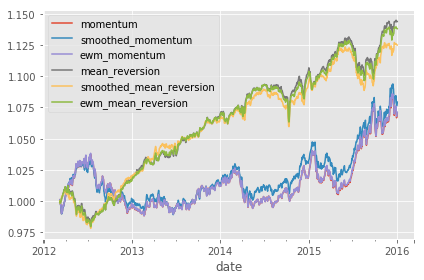

In [25]:
(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

In [26]:
factor_names = factor_data.keys()
factor_names

odict_keys(['momentum', 'smoothed_momentum', 'ewm_momentum', 'mean_reversion', 'smoothed_mean_reversion', 'ewm_mean_reversion'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x128b867f0>,
      dtype=object)

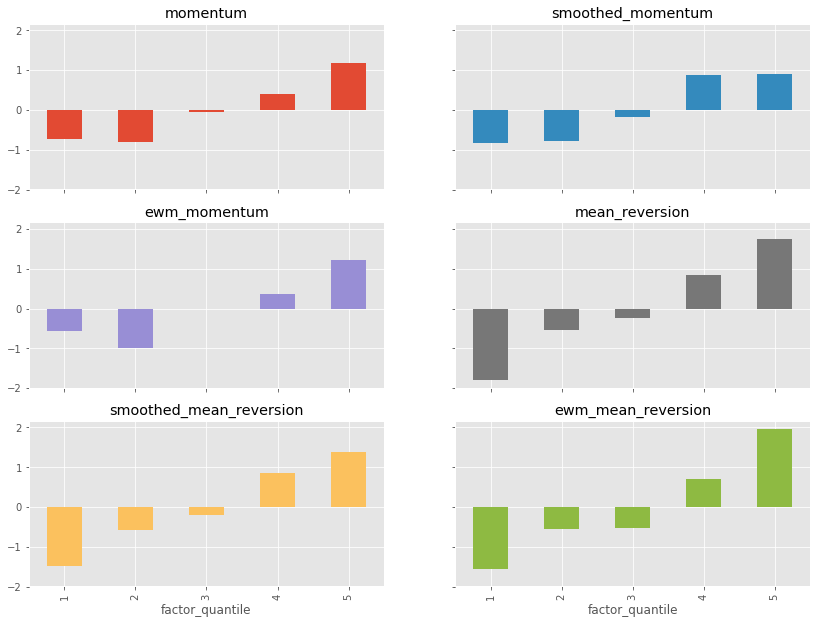

In [27]:
qr_factor_returns = pd.DataFrame()
for key, val in factor_data.items():
    qr_factor_returns[key] = al.performance.mean_return_by_quantile(val)[0].iloc[:,0]


(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

In [28]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

momentum                   0.58
smoothed_momentum          0.64
ewm_momentum               0.58
mean_reversion             1.59
smoothed_mean_reversion    1.40
ewm_mean_reversion         1.53
dtype: float64

# Looking at the data above, we'll use the second half of the year 2013 to back test the data since all factors seem to do well then.

In [29]:
index = smoothed_momentum.index.intersection(smoothed_mean_reversion.loc['2013-07-01':'2014-01-15'].index)

In [30]:
m = momentum.loc[index,:].stack()
print(m.shape)
sm = smoothed_momentum.loc[index,:].stack()
print(sm.shape)
mr = mean_reversion.loc[index, :].stack()
print(mr.shape)
smr = smoothed_mean_reversion.loc[index, :].stack()
print(smr.shape)

ewmmr = ewm_mean_reversion.loc[index, :].stack()
print(ewmmr.shape)
ewmm = ewm_momentum.loc[index, :].stack()
print(ewmm.shape)
adj_p = p.loc[index,:].copy()
print(adj_p.shape)

(102258,)
(102258,)
(102258,)
(102258,)
(102258,)
(102258,)
(138, 741)


Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% entries from factor data: 0.7% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
Dropped 0.7% en

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x127e4a198>,
      dtype=object)

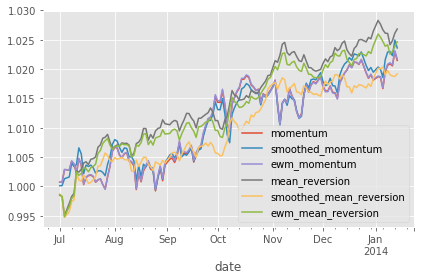

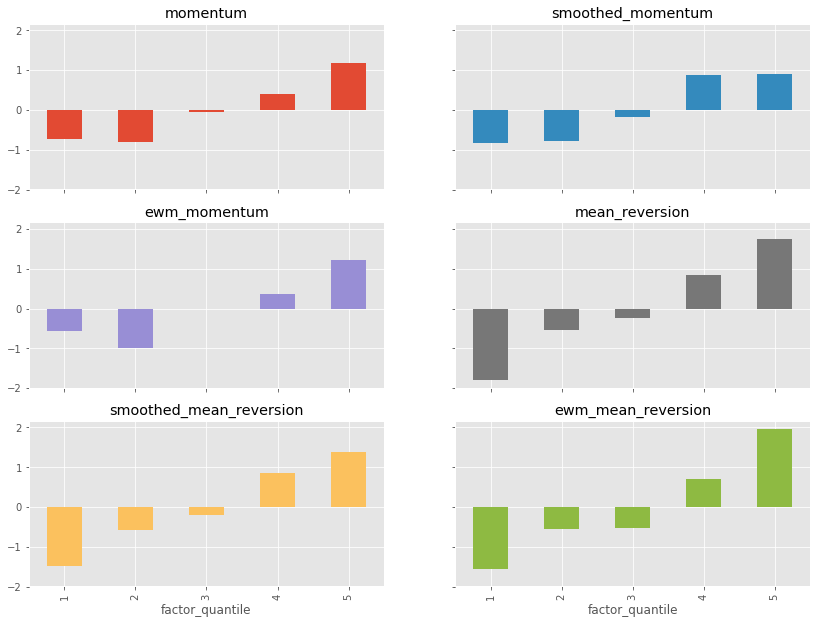

In [31]:
factor_data = OrderedDict()
factor_data['momentum'] = al.utils.get_clean_factor_and_forward_returns(m, adj_p, periods=[1])
factor_data['smoothed_momentum'] = al.utils.get_clean_factor_and_forward_returns(sm, adj_p, periods=[1])
factor_data['ewm_momentum'] = al.utils.get_clean_factor_and_forward_returns(ewmm, adj_p, periods=[1])
factor_data['mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(mr, adj_p, periods=[1])
factor_data['smoothed_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(smr, adj_p, periods=[1])
factor_data['ewm_mean_reversion'] = al.utils.get_clean_factor_and_forward_returns(ewmmr, adj_p, periods=[1])


factor_returns_df = pd.DataFrame()
for key, val in factor_data.items():
    factor_returns_df[key] = al.performance.factor_returns(val).iloc[:,0]

(1+factor_returns_df).cumprod().plot()
plt.tight_layout()

factor_names = factor_data.keys()
(10000 * qr_factor_returns).plot.bar(
    subplots=True,
    sharey = True,
    layout=(4,2),
    figsize=(14,14),
    legend=False
)

In [32]:
def get_sharpe_ratio(factor_returns, ann_factor):
    sharpe = factor_returns.mean() / (factor_returns.std())
    return sharpe * ann_factor

ann_factor = np.sqrt(252)
get_sharpe_ratio(factor_returns_df, ann_factor).round(2)

momentum                   1.60
smoothed_momentum          1.78
ewm_momentum               1.61
mean_reversion             3.13
smoothed_mean_reversion    2.25
ewm_mean_reversion         2.90
dtype: float64

## We will use smoothed_momentum (252 day return and 44 day smoothing period) and mean_reversion (two week return)

In [33]:
def build_frames(factor_data, returns, n_components):
    frames = OrderedDict()
    
    # setting the index
    alpha_names = list(factor_data.keys())
    index = factor_data[alpha_names[0]].index.get_level_values('date').unique()
    if len(alpha_names) > 0:
        for name in alpha_names[1:]:
            index = index.intersection(factor_data[name].index.get_level_values('date').unique())

    assert len(index) > 0   
    print('length of dates: ', len(index))
    
    
    for d in tqdm(index):
        d_str = d.strftime('%Y%m%d')
        # for the risk factors
        end_date = d
        start_date = d - dt.timedelta(days=365)
        rets = returns.loc[start_date:end_date,:]
        rets_shifted = returns.shift(-2).loc[start_date:end_date,:]
        
        if len(rets) != len(rets_shifted):
            raise Exception('returns and shifted returns are different shapes')
        
        if len(rets) < 250:
            raise Exception('Less than 250 days for risk model: Only {} days'.format(len(rets)))
            
        rm = RiskModelPCA(rets, n_components)        
        pnl_returns = rets_shifted.loc[d]
        pnl_returns.name = 'DlyReturnShifted'
        risk_names = rm.factor_exposures.columns
        
        # to add each factor series
        s = []
        for name in alpha_names:
            series = factor_data[name].loc[d, 'factor']
            series.name = name
            s.append(series)
        df = pd.concat([rm.factor_exposures, rm.total_var, rm.i_var_vector, *s, pnl_returns], axis=1)
        df['DataDate'] = d_str
        df = df.reset_index()
        df.rename(columns={'index':'ticker'}, inplace=True)
        frames[d_str] = df
        
    return frames, alpha_names, risk_names

In [68]:
alpha_factor_names = ['smoothed_momentum', 'mean_reversion']
fd = OrderedDict({k: factor_data[k] for k in alpha_factor_names})

frames, alpha_names, risk_names = build_frames(fd, returns, 2)
first = list(frames.keys())[0]
print(frames[first].head())

  0%|          | 0/137 [00:00<?, ?it/s]

length of dates:  137


100%|██████████| 137/137 [00:37<00:00,  3.68it/s]

  ticker  factor_0  factor_1  total_var  spec_var  mean_reversion  \
0   CSCO -0.033154  0.045992   0.065043  0.046743        0.028030   
1    UAL -0.029945 -0.065404   0.127026  0.108665       -0.836243   
2   TROW -0.043606 -0.010007   0.041157  0.014284        1.153922   
3   ISRG -0.028666 -0.012032   0.098984  0.087234        0.252274   
4    NVR -0.026641 -0.055110   0.053339  0.039275        1.466929   

   smoothed_momentum  DlyReturnShifted  DataDate  
0           1.093189          0.011102  20130701  
1           0.504549         -0.008257  20130701  
2          -0.051389          0.000946  20130701  
3          -1.714532         -0.002933  20130701  
4          -0.747480          0.001142  20130701  


In [69]:
len(list(frames.keys()))

137

In [70]:
def wins(x,a,b):
    return np.where(x <= a,a, np.where(x >= b, b, x))

20130701


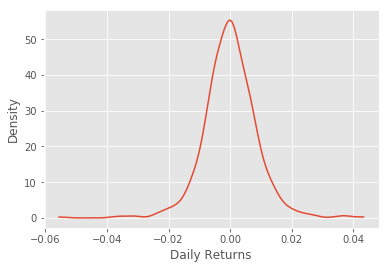

In [71]:
def density_plot(data): 
    density = gaussian_kde(data)
    xs = np.linspace(np.min(data),np.max(data),200)
    density.covariance_factor = lambda : .25
    density._compute_covariance()
    plt.plot(xs,density(xs))
    plt.xlabel('Daily Returns')
    plt.ylabel('Density')
    plt.show()
    
first = list(frames.keys())[0]
print(first)
test = frames[first]
test['DlyReturnShifted'] = wins(test['DlyReturnShifted'],-0.1,0.1)
density_plot(test['DlyReturnShifted'])

In [77]:
def get_formula(factors, Y):
    L = ["0"]
    L.extend(factors)
    return Y + " ~ " + " + ".join(L)

def factors_from_names(n):
    return list(filter(lambda x: x in [*risk_names, *alpha_names], n))

def estimate_factor_returns(df): 
    ## here we would build universe based on filters 
    estu = df.copy(deep=True)
  
    ## winsorize returns for fitting 
    estu['DlyReturnShifted'] = wins(estu['DlyReturnShifted'], -0.25, 0.25)
  
    all_factors = factors_from_names(list(df))
    form = get_formula(all_factors, "DlyReturnShifted")
    model = ols(form, data=estu)
    results = model.fit()
    return results

In [78]:
facret = OrderedDict()

for date in tqdm(frames):
    facret[date] = estimate_factor_returns(frames[date]).params

100%|██████████| 137/137 [00:00<00:00, 141.17it/s]


In [79]:
for date in facret:
    print(date)
    print(facret[date].head())
    print(facret[date].tail())
    break

20130701
factor_0            -0.008165
factor_1             0.016093
mean_reversion      -0.000331
smoothed_momentum    0.000049
dtype: float64
factor_0            -0.008165
factor_1             0.016093
mean_reversion      -0.000331
smoothed_momentum    0.000049
dtype: float64


In [80]:
my_dates = sorted(list(map(lambda date: pd.to_datetime(date, format='%Y%m%d'), frames.keys())))
my_dates[:5]

[Timestamp('2013-07-01 00:00:00'),
 Timestamp('2013-07-02 00:00:00'),
 Timestamp('2013-07-03 00:00:00'),
 Timestamp('2013-07-05 00:00:00'),
 Timestamp('2013-07-08 00:00:00')]

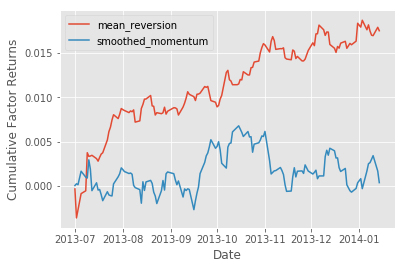

In [81]:
facret_df = pd.DataFrame(index = my_dates)
for date_ in my_dates: 
    for alp in alpha_names: 
        facret_df.at[date_, alp] = facret[date_.strftime('%Y%m%d')][alp]

for column in facret_df.columns:
    plt.plot(facret_df[column].cumsum(), label=column)
plt.legend(loc='upper left')
plt.xlabel('Date')
plt.ylabel('Cumulative Factor Returns')
plt.show()

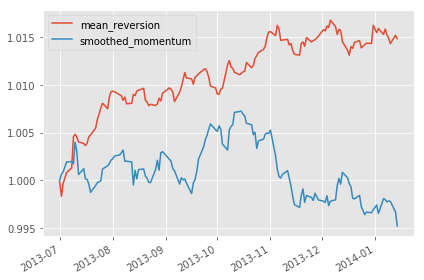

In [43]:
(1+facret_df).cumprod().plot()
plt.tight_layout()